# SN Fits as Reference

Set of SNooPy fits using all and grJH bands, and Gaussian Process fits of J and H bands (independently).

In [2]:
import snpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import george
import scipy

import os
import glob

from multiprocessing import Pool

%config InlineBackend.figure_format = 'retina'
print(f'SNooPy version: v{snpy.__version__}')

SNOOPY_MODEL = 'max_model'
OUTPUT_DIR = 'reference_fits'
PROCESSES = 8

SNooPy version: v2.6.0


## Gaussian Process fit functions

In [5]:
def get_parameter(sn, parameter, include_sys=False):
    """Obtains the value of the given parameter and
    the total (systematics + statistical) uncertainty
    of a fitted SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    parameter: str
        Parameter to extract.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.
        
    Returns
    =======
    value: float
        Value of the parameter.
    err: float
        Total uncertainty in the parameter. 
    """
    
    value = sn.parameters[parameter]
    stats_err = sn.errors[parameter]
    if include_sys:
        sys_err = sn.systematics()[parameter]
    else:
        sys_err = 0.0
    err = np.sqrt(stats_err**2 + sys_err**2)
    
    return value, err

def gp_lc_fit(x_data, y_data, yerr_data=0.0, kernel='matern52'):
    """Fits a single light curve with gaussian process.
    
    **Note:** The package ``george`` is used for the gaussian process fit.
    
    Parameters
    =======
    x_data : array
        Independent values.
    y_data : array
        Dependent values.
    yerr_data : array, default ``0.0``
        Dependent value errors.
    kernel : str, default ``matern52``
        Kernel to be used with the gaussian process. E.g.,
        ``matern52``, ``matern32``, ``squaredexp``.
        
    Returns
    =======
    x_pred : array
        Interpolated x-axis values.
    mean : array
        Interpolated  values.
    std : array
        Standard deviation (:math:`1\sigma`) of the interpolation.
    """

    # define the objective function (negative log-likelihood in this case)
    def neg_log_like(params):
        """Negative log-likelihood."""
        gp.set_parameter_vector(params)
        log_like = gp.log_likelihood(y, quiet=True)
        if np.isfinite(log_like):
            return -log_like
        else:
            return np.inf

    # and the gradient of the objective function
    def grad_neg_log_like(params):
        """Gradient of the negative log-likelihood."""
        gp.set_parameter_vector(params)
        return -gp.grad_log_likelihood(y, quiet=True)

    x, y, yerr = np.copy(x_data), np.copy(y_data), np.copy(yerr_data)

    x_min, x_max = x.min(), x.max()

    y_norm = y.max()
    y /= y_norm
    yerr /= y_norm

    var, length_scale = np.var(y), np.diff(x).max()

    k1 = george.kernels.ConstantKernel(np.log(var))

    if kernel == 'matern52':
        k2 = george.kernels.Matern52Kernel(length_scale**2)
    elif kernel == 'matern32':
        k2 = george.kernels.Matern32Kernel(length_scale**2)
    elif kernel == 'squaredexp':
        k2 = george.kernels.ExpSquaredKernel(length_scale**2)
    else:
        raise ValueError(f'"{kernel}" is not a valid kernel.')

    ker = k1*k2

    gp = george.GP(kernel=ker, fit_mean=True)
    # initial guess
    gp.compute(x, yerr)

    # optimization routine for hyperparameters
    p0 = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    results = scipy.optimize.minimize(neg_log_like, p0, jac=grad_neg_log_like,
                                            method="L-BFGS-B", options={'maxiter':30})
    gp.set_parameter_vector(results.x)

    step = 0.1
    x_pred = np.arange(x_min-10, x_max+step+10, step)

    mean, var = gp.predict(y, x_pred, return_var=True)
    std = np.sqrt(var)

    mean, std = mean*y_norm, std*y_norm

    return x_pred, mean, std

def gp_fit(sn):
    """Fits the NIR light curves of a SN with Gaussian Process.
    
    **Note:** if the SN contains J and Jrc2 bands, these are
    joined and treated as one for the GP fit.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Returns
    =======
    sn object.
    """
        
    sn.choose_model(SNOOPY_MODEL)
    
    NIR_bands = ['J', 'H']
    bands = [band for band in sn.allbands() if band in NIR_bands]
    
    for band in bands:
        if len(sn.data[band].MJD)>1:
            # SNooPy GP fit for plotting reference only
            sn.data[band].curve_fit(method='gp')

            data = sn.data[band]
            mjd, mag, mag_err = data.MJD, data.magnitude, data.e_mag
        
            gp_mjd, gp_mag, gp_mag_err = gp_lc_fit(mjd, mag, mag_err)
            imax = np.argmin(gp_mag)  # index of peak mag

            # save values
            sn.data[band].gp_mjd = gp_mjd
            sn.data[band].gp_mag = gp_mag
            sn.data[band].gp_mag_err = gp_mag_err
            sn.data[band].gp_max = gp_mag[imax]
            sn.data[band].gp_max_err = gp_mag_err[imax]
        else:
            sn.data[band].gp_mjd = np.nan
            sn.data[band].gp_mag = np.nan
            sn.data[band].gp_mag_err = np.nan
            sn.data[band].gp_max = np.nan
            sn.data[band].gp_max_err = np.nan
            
    # save object and plot
    output_snpy = os.path.join(OUTPUT_DIR, f'{sn.name}_gp.snpy')
    sn.save(output_snpy)
    output_plot = os.path.join(OUTPUT_DIR, f'{sn.name}_gp.jpeg')
    sn.plot(outfile=output_plot)
    
    return sn

## SNooPy fit functions

In [6]:
def gr_fit(sn):
    """Fits gr-bands light curves of a SN with SNooPy.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.

    Returns
    =======
    sn object.
    """
    
    bands = ['g', 'r']
    
    sn.choose_model(SNOOPY_MODEL)
    sn.fit(bands)
    
    Tmax, Tmax_err = get_parameter(sn, 'Tmax')
    sn.gr_Tmax = Tmax
    sn.gr_Tmax_err = Tmax_err
    
    st, st_err = get_parameter(sn, 'st')
    sn.gr_st = st
    sn.gr_st_err = st_err
    
    for band in bands:
        data = sn.data[band]
        mjd, mag, mag_err = data.MJD, data.magnitude, data.e_mag
        
        model_mjd = np.arange(mjd.min()-10, mjd.max()+10, 0.1)
        model_mag, model_mag_err, _ = sn.model(band, model_mjd)
        
        mmax, mmax_err = get_parameter(sn, band+'max')
        
        # save values
        sn.data[band].gr_mjd = model_mjd
        sn.data[band].gr_mag = model_mag
        sn.data[band].gr_mag_err = model_mag_err
        sn.data[band].gr_max = mmax
        sn.data[band].gr_max_err = mmax_err
        
    # save object and plot
    output_snpy = os.path.join(OUTPUT_DIR, f'{sn.name}_gr.snpy')
    sn.save(output_snpy)
    output_plot = os.path.join(OUTPUT_DIR, f'{sn.name}_gr.jpeg')
    sn.plot(outfile=output_plot)
    
    return sn

def grJH_fit(sn):
    """Fits grJH-bands light curves of a SN with SNooPy.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.

    Returns
    =======
    sn object.
    """
    
    grJH_bands = ['g', 'r', 'J', 'H']
    bands = [band for band in sn.allbands() if band in grJH_bands]
    
    sn.choose_model(SNOOPY_MODEL)
    sn.fit(bands)
    
    Tmax, Tmax_err = get_parameter(sn, 'Tmax')
    sn.grJH_Tmax = Tmax
    sn.grJH_Tmax_err = Tmax_err
    
    st, st_err = get_parameter(sn, 'st')
    sn.grJH_st = st
    sn.grJH_st_err = st_err
    
    for band in bands:
        data = sn.data[band]
        mjd, mag, mag_err = data.MJD, data.magnitude, data.e_mag
        
        model_mjd = np.arange(mjd.min()-10, mjd.max()+10, 0.1)
        model_mag, model_mag_err, _ = sn.model(band, model_mjd)
        
        mmax, mmax_err = get_parameter(sn, band+'max')
        
        # save values
        sn.data[band].grJH_mjd = model_mjd
        sn.data[band].grJH_mag = model_mag
        sn.data[band].grJH_mag_err = model_mag_err
        sn.data[band].grJH_max = mmax
        sn.data[band].grJH_max_err = mmax_err
        
    # save object and plot
    output_snpy = os.path.join(OUTPUT_DIR, f'{sn.name}_grJH.snpy')
    sn.save(output_snpy)
    output_plot = os.path.join(OUTPUT_DIR, f'{sn.name}_grJH.jpeg')
    sn.plot(outfile=output_plot)
    
    return sn

def Allminusu_fit(sn):
    """Fits ALL the light curves of a SN with SNooPy except
    for the u band.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.

    Returns
    =======
    sn object.
    """
    
    bands = sn.allbands()
    if 'u' in bands:
        bands.remove('u')

    sn.choose_model(SNOOPY_MODEL)
    sn.fit(bands)
    
    Tmax, Tmax_err = get_parameter(sn, 'Tmax')
    sn.Allminusu_Tmax = Tmax
    sn.Allminusu_Tmax_err = Tmax_err
    
    st, st_err = get_parameter(sn, 'st')
    sn.Allminusu_st = st
    sn.Allminusu_st_err = st_err
        
    for band in bands:
        data = sn.data[band]
        mjd, mag, mag_err = data.MJD, data.magnitude, data.e_mag
        
        model_mjd = np.arange(mjd.min()-10, mjd.max()+10, 0.1)
        model_mag, model_mag_err, _ = sn.model(band, model_mjd)
        
        mmax, mmax_err = get_parameter(sn, band+'max')
        
        # save values
        sn.data[band].Allminusu_mjd = model_mjd
        sn.data[band].Allminusu_mag = model_mag
        sn.data[band].Allminusu_mag_err = model_mag_err
        sn.data[band].Allminusu_max = mmax
        sn.data[band].Allminusu_max_err = mmax_err
        
    # save object and plot
    output_snpy = os.path.join(OUTPUT_DIR, f'{sn.name}_Allminusu.snpy')
    sn.save(output_snpy)
    output_plot = os.path.join(OUTPUT_DIR, f'{sn.name}_Allminusu.jpeg')
    sn.plot(outfile=output_plot)
    
    return sn

def AllBands_fit(sn):
    """Fits ALL the light curves of a SN with SNooPy.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.

    Returns
    =======
    sn object.
    """
    
    sn.choose_model(SNOOPY_MODEL)
    sn.fit()
    
    Tmax, Tmax_err = get_parameter(sn, 'Tmax')
    sn.AllBands_Tmax = Tmax
    sn.AllBands_Tmax_err = Tmax_err
    
    st, st_err = get_parameter(sn, 'st')
    sn.AllBands_st = st
    sn.AllBands_st_err = st_err
    
    bands = sn.allbands()
    
    for band in bands:
        data = sn.data[band]
        mjd, mag, mag_err = data.MJD, data.magnitude, data.e_mag
        
        model_mjd = np.arange(mjd.min()-10, mjd.max()+10, 0.1)
        model_mag, model_mag_err, _ = sn.model(band, model_mjd)
        
        mmax, mmax_err = get_parameter(sn, band+'max')
        
        # save values
        sn.data[band].AllBands_mjd = model_mjd
        sn.data[band].AllBands_mag = model_mag
        sn.data[band].AllBands_mag_err = model_mag_err
        sn.data[band].AllBands_max = mmax
        sn.data[band].AllBands_max_err = mmax_err
        
    # save object and plot
    output_snpy = os.path.join(OUTPUT_DIR, f'{sn.name}_AllBands.snpy')
    sn.save(output_snpy)
    output_plot = os.path.join(OUTPUT_DIR, f'{sn.name}_AllBands.jpeg')
    sn.plot(outfile=output_plot)
    
    return sn

## Results-saving functions

In [7]:
def save_results(sn):
    """Save the results of the fits of a SN after using
    `gp_fit`, `gr_fit`, `grJH_fit`, `Allminusu_fit` and 
    `AllBands_fit`.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    """
    
    results_dict = {'name':sn.name,
                    'Tmax_gr':sn.gr_Tmax,
                    'Tmax_err_gr':sn.gr_Tmax_err,
                    'Tmax_grJH':sn.grJH_Tmax,
                    'Tmax_err_grJH':sn.grJH_Tmax_err,
                    'Tmax_Allminusu':sn.Allminusu_Tmax,
                    'Tmax_err_Allminusu':sn.Allminusu_Tmax_err,
                    'Tmax_AllBands':sn.AllBands_Tmax,
                    'Tmax_err_AllBands':sn.AllBands_Tmax_err,
                    'st_gr':sn.gr_st,
                    'st_err_gr':sn.gr_st_err,
                    'st_grJH':sn.grJH_st,
                    'st_err_grJH':sn.grJH_st_err,
                    'st_Allminusu':sn.Allminusu_st,
                    'st_err_Allminusu':sn.Allminusu_st_err,
                    'st_AllBands':sn.AllBands_st,
                    'st_err_AllBands':sn.AllBands_st_err,
                   }
    
    # optical results
    for band in ['g', 'r']:
        mmax_dict = {f'{band}max_gr':sn.data[band].gr_max,
                     f'{band}max_err_gr':sn.data[band].gr_max_err,
                     f'{band}max_grJH':sn.data[band].grJH_max,
                     f'{band}max_err_grJH':sn.data[band].grJH_max_err,
                     f'{band}max_Allminusu':sn.data[band].Allminusu_max,
                     f'{band}max_err_Allminusu':sn.data[band].Allminusu_max_err,
                     f'{band}max_AllBands':sn.data[band].AllBands_max,
                     f'{band}max_err_AllBands':sn.data[band].AllBands_max_err,
        }
        results_dict.update(mmax_dict)
    
    # NIR results
    JH_bands = ['J', 'H']
    bands = [band for band in sn.allbands() if band in JH_bands]
    
    for band in bands:        
        mmax_dict = {f'{band}max_gp':sn.data[band].gp_max,
                     f'{band}max_err_gp':sn.data[band].gp_max_err,
                     f'{band}max_grJH':sn.data[band].grJH_max,
                     f'{band}max_err_grJH':sn.data[band].grJH_max_err,
                     f'{band}max_Allminusu':sn.data[band].Allminusu_max,
                     f'{band}max_err_Allminusu':sn.data[band].Allminusu_max_err,
                     f'{band}max_AllBands':sn.data[band].AllBands_max,
                     f'{band}max_err_AllBands':sn.data[band].AllBands_max_err,
        }
        
        results_dict.update(mmax_dict)
        
    return results_dict

def full_fit(sn):
    """Fits a SN with `gp_fit`, `gr_fit`, `grJH_fit`, 
    `Allminusu_fit`and `AllBands_fit`. The combined results 
    are saved in a single snpy file.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Results
    =======
    sn_df: pandas DataFrame
        Dataframe with the results of the SN. E.g.,
        Tmax, gmax, rmax, Jmax, Hmax, for the different fits. 
    """
    
    sn = gp_fit(sn)
    sn = gr_fit(sn)
    sn = grJH_fit(sn)
    sn = Allminusu_fit(sn)
    sn = AllBands_fit(sn)
    output_file = os.path.join(OUTPUT_DIR, f'{sn.name}.snpy')
    sn.save(output_file)
    
    results_dict = save_results(sn)
    sn_df = pd.DataFrame(results_dict, index=[0])
    
    return sn_df

### Fit multiple SNe

In [8]:
def pool_fit(sn_file):
    '''Fits a SN with SNooPy and returns the saved results.
    
    Parameters
    ==========
    sn_file: str
        SN file in SNooPy format.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''
    
    sn = snpy.import_lc(sn_file)
    
    if sn.name in ['SN2005el', 'SN2008fp']:
        sn.data.pop('K')
        
    try:
        sn_df = full_fit(sn)
        return sn_df
    except Exception as message:
        print(f'Unable to fit {sn.name}: {message}')

In [7]:
with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

results = Pool(PROCESSES).map(pool_fit, (sn_file for sn_file in sn_files))

master_df = pd.concat(results, ignore_index=True)
master_df.to_csv('reference_results.csv', index=False)

Warning!  0.000000% of MC realizations had good dm15
Unable to fit SN2006mr: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Warning!  0.000000% of MC realizations had good dm15
Warning!  13.000000% of MC realizations had good dm15
Unable to fit LSQ12hvj: band g not defined in this SN object
Unable to fit ASAS14jz: Cannot interpolate data with less than two distinct data points
Unable to fit SN2014dl: band g not defined in this SN object
Unable to fit LSQ14ip: Cannot interpolate data with less than two distinct data points
Warning!  76.000000% of MC realizations had good Tmax
Warning!  76.000000% of MC realizations had good Mmax
Warning!  76.000000% of MC realizations had good dm15
Warning!  0.000000% of MC realizations had good dm15
Unable to fit LSQ12fvl: band g not defined in this SN object
Warning!  41.000000% of MC realizations had good Tmax
Warning!  41.000000% of MC realizations had good Mmax


/home/tomas/anaconda3/lib/python3.6/site-packages/snpy/model.py:310: RuntimeWarning: overflow encountered in power
  f = power(10, -0.4*(mod - self.parent.data[band].filter.zp))
/home/tomas/anaconda3/lib/python3.6/site-packages/snpy/model.py:313: RuntimeWarning: invalid value encountered in multiply
  cov_f = power(f*err/1.0857,2)


Unable to fit SN2008fp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.
Unable to fit PTF14yy: Cannot interpolate data with less than two distinct data points
Warning!  60.000000% of MC realizations had good Tmax
Warning!  60.000000% of MC realizations had good Mmax
Warning!  60.000000% of MC realizations had good dm15
Warning!  0.000000% of MC realizations had good dm15
Warning!  0.000000% of MC realizations had good dm15
Unable to fit LSQ14foj: band g not defined in this SN object
Warning!  0.000000% of MC realizations had good dm15
Warning!  0.000000% of MC realizations had good dm15
Warning!  47.000000% of MC realizations had good Tmax
Warning!  47.000000% of MC realizations had good Mmax
Warning!  45.000000% of MC realizations had good dm15
Warning!  46.000000% of MC realizations had good Tmax
Warning!  46.000000% of MC realizations had good Mmax
Warning!  46.000000% of MC realizati

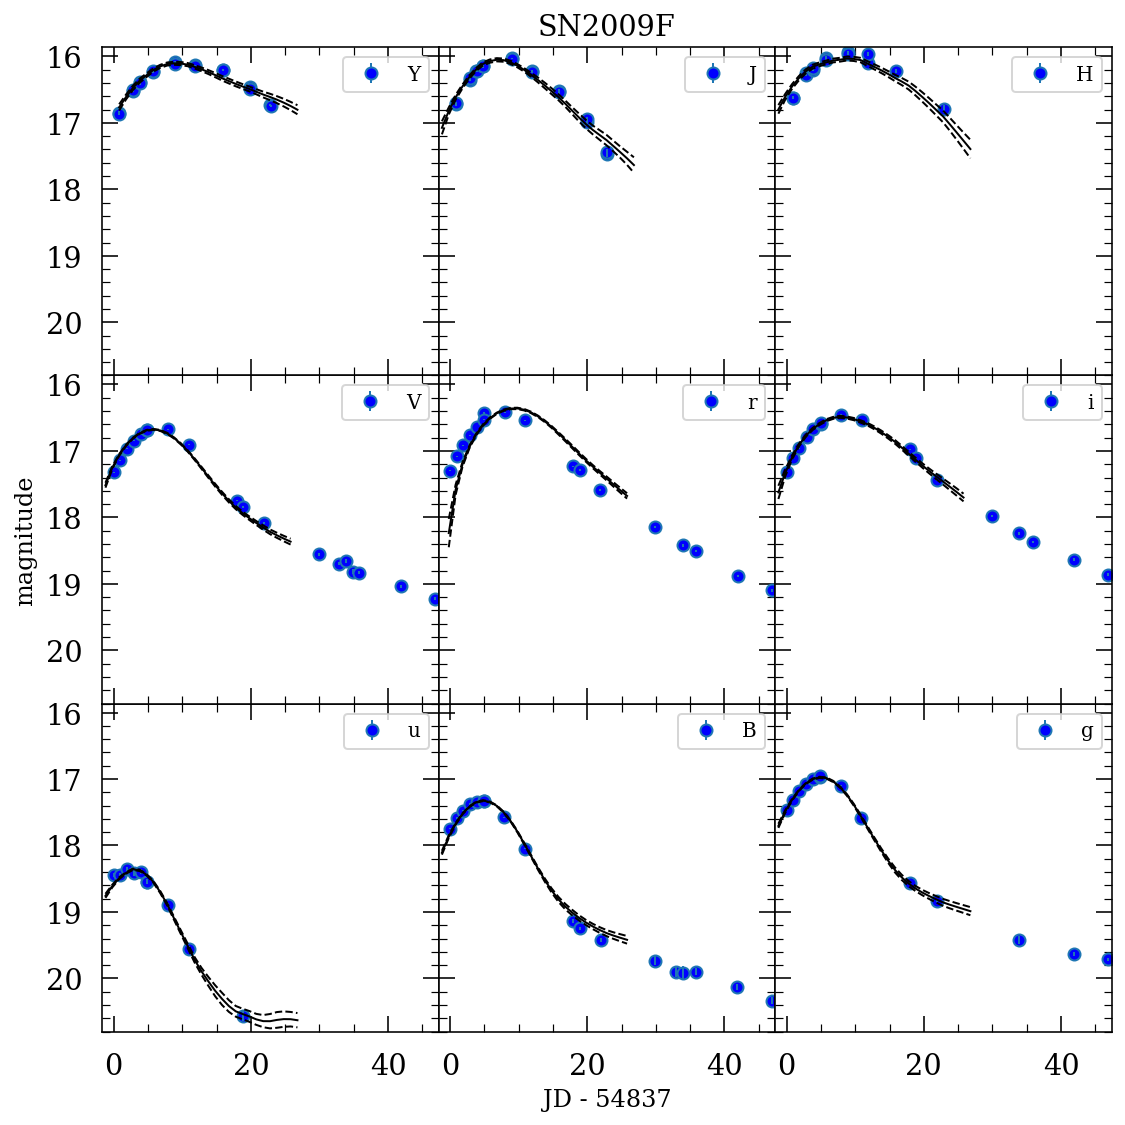

In [39]:
sn_name = 'SN2009F'
sn_file = os.path.join('csp_data', f'{sn_name}_snpy.txt')
sn = snpy.import_lc(sn_file)
sn.choose_model(SNOOPY_MODEL)

#sn.k_version = '91bg'
sn.fit(['B'], st=0.3)
sn.fit(['B'])
#sn.fit(st=0.3)
sn.fit(st=sn.st, Tmax=sn.Tmax)
sn.fit()

In [37]:
sn.summary()

--------------------------------------------------------------------------------
SN  SN2009F
z = 0.0129          zcmb = 0.0129          ra= 74.84820         dec=-11.13060 
Data in the following bands: g,  r,  i,  u,  V,  B,  Y,  J,  H,  
Fit results (if any):
   st = 0.017  +/-  0.000  +/- 0.030 (sys)
   Tmax = 54842.750  +/-  0.000  +/- 0.340 (sys)
   gmax = 14.943  +/-  0.000  +/- 0.014 (sys)
   rmax = 13.742  +/-  0.000  +/- 0.022 (sys)
   imax = 14.964  +/-  0.000  +/- 0.022 (sys)
   umax = 49.115  +/-  0.000  +/- 0.030 (sys)
   Vmax = 14.815  +/-  0.000  +/- 0.019 (sys)
   Bmax = 14.507  +/-  0.000  +/- 0.012 (sys)
   Ymax = 16.651  +/-  0.000  +/- 0.050 (sys)
   Jmax = 15.905  +/-  0.000  +/- 0.044 (sys)
   Hmax = 17.993  +/-  0.000  +/- 0.055 (sys)


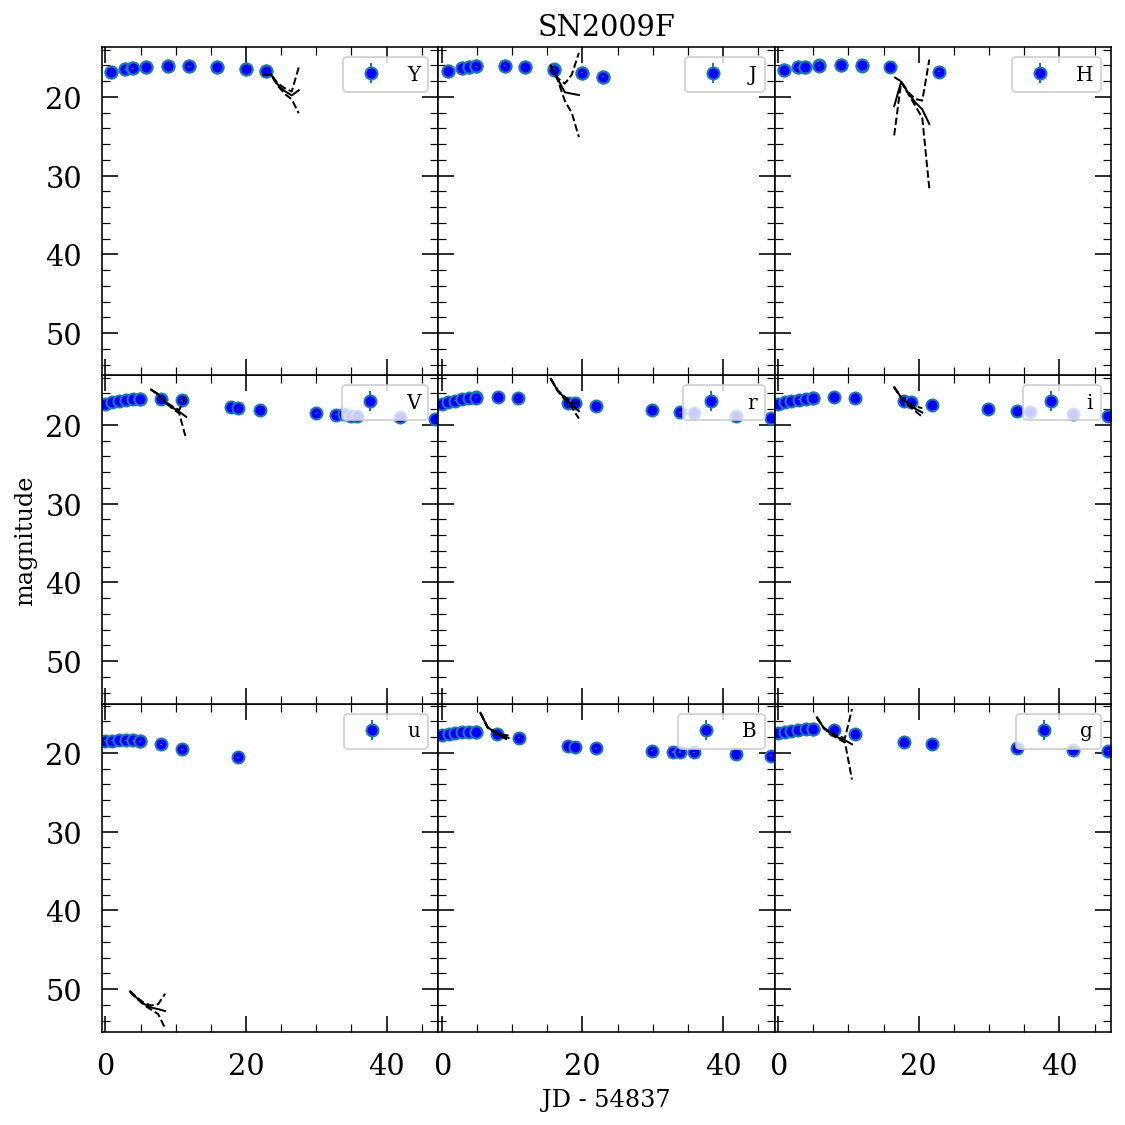

In [38]:
sn.plot()